# Compare standard decoding analyses to CCGP for rule decoding across cortex

#### 1/6/2021

In [1]:
import numpy as np
import scipy.stats as stats
import h5py
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import pandas as pd
import multiprocessing as mp
import statsmodels.stats.multitest as mc
import os
%matplotlib inline

#### Parameter set up

In [2]:
projectdir = '../../'
datadir = projectdir + 'data/' 
resultdir = projectdir + 'data/results/'
subjNums = ['013','014','016','017','018','021','023','024','026','027','028',
            '030','031','032','033','034','035','037','038','039','040','041',
            '042','043','045','046','047','048','049','050','053','055','056',
            '057','058','062','063','066','067','068','069','070','072','074',
            '075','076','077','081','085','086','087','088','090','092','093',
            '094','095','097','098','099','101','102','103','104','105','106',
            '108','109','110','111','112','114','115','117','119','120','121',
            '122','123','124','125','126','127','128','129','130','131','132',
            '134','135','136','137','138','139','140','141']

glasserfile = projectdir + 'data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = nib.load(glasserfile).get_fdata()
glasser = np.squeeze(glasser)
rois = np.arange(1,361)

#### Load in CAB-NP ROI labels
cabn_labels = pd.read_csv(projectdir + 'data/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR_LabelKey.txt',header=0,delimiter='\t')
df_labels = cabn_labels.iloc[0:360]
df_labels.reset_index()
del df_labels['INDEX'], df_labels["KEYVALUE"]

# Using final partition
networkdef = df_labels['NETWORKKEY'].values
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}

fpn_ind = np.where(networkdef==networkmappings['fpn'])[0]
con_ind = np.where(networkdef==networkmappings['con'])[0]
ccn_ind = np.hstack((fpn_ind,con_ind))

nParcels = 360

# Surface mapping function

In [3]:
def mapBackToSurface(array,filename):
    """ 
    array can either be 360 array or ~59k array. If 360, will automatically map back to ~59k
    """
    #### Map back to surface
    if array.shape[0]==360:
        out_array = np.zeros((glasser.shape[0],3))

        roicount = 0 
        for roi in range(360):
            for col in range(array.shape[1]):
                vertex_ind = np.where(glasser==roi+1)[0]
                out_array[vertex_ind,col] = array[roicount,col]

            roicount += 1

    else:
        out_array = array

    #### 
    # Write file to csv and run wb_command
    np.savetxt(filename + '.csv', out_array,fmt='%s')
    wb_file = filename + '.dscalar.nii'
    wb_command = 'wb_command -cifti-convert -from-text ' + filename + '.csv ' + glasserfile + ' ' + wb_file + ' -reset-scalars'
    os.system(wb_command)
    os.remove(filename + '.csv')

# Logic rule decoding and CCGP

No handles with labels found to put in legend.


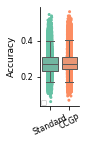

In [64]:
decoding_dir = resultdir + 'DecodingAnalyses/'
classifier = 'distance'
rule = 'Logic'
norm = ''
logic_dec = np.loadtxt(decoding_dir + 'Subj' + rule + 'Decoding_' + classifier + norm + '.csv')
logic_ccgp = np.loadtxt(decoding_dir + 'Subj' + rule + 'CCGP_' + classifier + norm +  '.csv')

# Plot bar plot and statistical testing
df_logic = {}
df_logic['Classifier'] = []
df_logic['Decoding'] = []
df_logic['Parcel'] = []
df_logic['Accuracy'] = []
df_logic['Subject'] = []
for roi in range(nParcels): 
    for subj in range(len(subjNums)):
        df_logic['Classifier'].append(classifier)
        df_logic['Decoding'].append('Standard')
        df_logic['Parcel'].append(roi)
        df_logic['Subject'].append(subj)
        df_logic['Accuracy'].append(logic_dec[roi,subj])
        #
        df_logic['Classifier'].append(classifier)
        df_logic['Decoding'].append('CCGP')
        df_logic['Parcel'].append(roi)
        df_logic['Subject'].append(subj)
        df_logic['Accuracy'].append(logic_ccgp[roi,subj])
        
df_logic = pd.DataFrame(df_logic)

plt.figure(figsize=(1.3,2.1))
sns.stripplot(x="Decoding",y="Accuracy",data=df_logic,dodge=True,size=3,palette="Set2",zorder=0)
ax = sns.boxplot(x="Decoding",y="Accuracy",data=df_logic,sym='',whis=[2.5,97.5],palette="Set2",linewidth=1.0) #,order=hierarchy_ind,palette=networkpalette)
plt.xticks(rotation=25,fontsize=8)
# plt.xlabel('Network',fontsize=10);
plt.xlabel(None,fontsize=9)
plt.ylabel('Accuracy',fontsize=9);
plt.yticks(fontsize=8)
# plt.ylim([-0.55,1.2])
# plt.title('',fontsize=10)
# plt.title('Representational\nsegregation', fontsize=10);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[:2], labels[:2], loc=3, borderaxespad=0.2, prop={'size': 6})
plt.tight_layout()
sns.despine()

# Run statistical analyses
t_dec, p_dec = stats.ttest_1samp(logic_dec,0.25,axis=1)
q_dec = mc.fdrcorrection(p_dec)[1]
t_ccgp, p_ccgp = stats.ttest_1samp(logic_ccgp,0.25,axis=1)
q_ccgp = mc.fdrcorrection(p_ccgp)[1]

# Map to surface significant effects for decoding and ccgp
sig_effects = np.zeros((nParcels,2))
sig_effects[:,0] = np.multiply(np.mean(logic_dec,axis=1),q_dec<0.05)
sig_effects[:,1] = np.multiply(np.mean(logic_ccgp,axis=1),q_ccgp<0.05)

outfilename = decoding_dir + 'Surface_' + rule + '_' + classifier + norm
mapBackToSurface(sig_effects,outfilename)

# Sensory rule decoding and CCGP

No handles with labels found to put in legend.


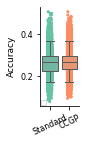

In [65]:
decoding_dir = resultdir + 'DecodingAnalyses/'
classifier = 'distance'
rule = 'Sensory'
norm = ''
sensory_dec = np.loadtxt(decoding_dir + 'Subj' + rule + 'Decoding_' + classifier + norm + '.csv')
sensory_ccgp = np.loadtxt(decoding_dir + 'Subj' + rule + 'CCGP_' + classifier + norm + '.csv')

# Plot bar plot and statistical testing
df_sensory = {}
df_sensory['Classifier'] = []
df_sensory['Decoding'] = []
df_sensory['Parcel'] = []
df_sensory['Accuracy'] = []
df_sensory['Subject'] = []
for roi in range(nParcels): 
    for subj in range(len(subjNums)):
        df_sensory['Classifier'].append(classifier)
        df_sensory['Decoding'].append('Standard')
        df_sensory['Parcel'].append(roi)
        df_sensory['Subject'].append(subj)
        df_sensory['Accuracy'].append(sensory_dec[roi,subj])
        #
        df_sensory['Classifier'].append(classifier)
        df_sensory['Decoding'].append('CCGP')
        df_sensory['Parcel'].append(roi)
        df_sensory['Subject'].append(subj)
        df_sensory['Accuracy'].append(sensory_ccgp[roi,subj])
        
df_sensory = pd.DataFrame(df_sensory)

plt.figure(figsize=(1.3,2.1))
sns.stripplot(x="Decoding",y="Accuracy",data=df_sensory,dodge=True,size=3,palette="Set2",zorder=0)
ax = sns.boxplot(x="Decoding",y="Accuracy",data=df_sensory,sym='',whis=[2.5,97.5],palette="Set2",linewidth=1.0) #,order=hierarchy_ind,palette=networkpalette)
plt.xticks(rotation=25,fontsize=8)
# plt.xlabel('Network',fontsize=10);
plt.xlabel(None,fontsize=9)
plt.ylabel('Accuracy',fontsize=9);
plt.yticks(fontsize=8)
# plt.ylim([-0.55,1.2])
# plt.title('',fontsize=10)
# plt.title('Representational\nsegregation', fontsize=10);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[:2], labels[:2], loc=3, borderaxespad=0.2, prop={'size': 6})
plt.tight_layout()
sns.despine()

# Run statistical analyses
t_dec, p_dec = stats.ttest_1samp(sensory_dec,0.25,axis=1)
q_dec = mc.fdrcorrection(p_dec)[1]
t_ccgp, p_ccgp = stats.ttest_1samp(sensory_ccgp,0.25,axis=1)
q_ccgp = mc.fdrcorrection(p_ccgp)[1]

# Map to surface significant effects for decoding and ccgp
sig_effects = np.zeros((nParcels,2))
sig_effects[:,0] = np.multiply(np.mean(sensory_dec,axis=1),q_dec<0.05)
sig_effects[:,1] = np.multiply(np.mean(sensory_ccgp,axis=1),q_ccgp<0.05)

outfilename = decoding_dir + 'Surface_' + rule + '_' + classifier + norm
mapBackToSurface(sig_effects,outfilename)

# Motor rule decoding and CCGP

No handles with labels found to put in legend.


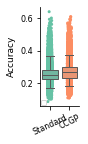

In [67]:
decoding_dir = resultdir + 'DecodingAnalyses/'
classifier = 'svm'
rule = 'Motor'
norm = ''
motor_dec = np.loadtxt(decoding_dir + 'Subj' + rule + 'Decoding_' + classifier + norm + '.csv')
motor_ccgp = np.loadtxt(decoding_dir + 'Subj' + rule + 'CCGP_' + classifier + norm + '.csv')

# Plot bar plot and statistical testing
df_motor = {}
df_motor['Classifier'] = []
df_motor['Decoding'] = []
df_motor['Parcel'] = []
df_motor['Accuracy'] = []
df_motor['Subject'] = []
for roi in range(nParcels): 
    for subj in range(len(subjNums)):
        df_motor['Classifier'].append(classifier)
        df_motor['Decoding'].append('Standard')
        df_motor['Parcel'].append(roi)
        df_motor['Subject'].append(subj)
        df_motor['Accuracy'].append(motor_dec[roi,subj])
        #
        df_motor['Classifier'].append(classifier)
        df_motor['Decoding'].append('CCGP')
        df_motor['Parcel'].append(roi)
        df_motor['Subject'].append(subj)
        df_motor['Accuracy'].append(motor_ccgp[roi,subj])
        
df_motor = pd.DataFrame(df_motor)

plt.figure(figsize=(1.3,2.1))
sns.stripplot(x="Decoding",y="Accuracy",data=df_motor,dodge=True,size=3,palette="Set2",zorder=0)
ax = sns.boxplot(x="Decoding",y="Accuracy",data=df_motor,sym='',whis=[2.5,97.5],palette="Set2",linewidth=1.0) #,order=hierarchy_ind,palette=networkpalette)
plt.xticks(rotation=25,fontsize=8)
# plt.xlabel('Network',fontsize=10);
plt.xlabel(None,fontsize=9)
plt.ylabel('Accuracy',fontsize=9);
plt.yticks(fontsize=8)
# plt.ylim([-0.55,1.2])
# plt.title('',fontsize=10)
# plt.title('Representational\nsegregation', fontsize=10);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[:2], labels[:2], loc=3, borderaxespad=0.2, prop={'size': 6})
plt.tight_layout()
sns.despine()

# Run statistical analyses
t_dec, p_dec = stats.ttest_1samp(motor_dec,0.25,axis=1)
q_dec = mc.fdrcorrection(p_dec)[1]
t_ccgp, p_ccgp = stats.ttest_1samp(motor_ccgp,0.25,axis=1)
q_ccgp = mc.fdrcorrection(p_ccgp)[1]

# Map to surface significant effects for decoding and ccgp
sig_effects = np.zeros((nParcels,2))
sig_effects[:,0] = np.multiply(np.mean(motor_dec,axis=1),q_dec<.05)
sig_effects[:,1] = np.multiply(np.mean(motor_ccgp,axis=1),q_ccgp<.05)

outfilename = decoding_dir + 'Surface_' + rule + '_' + classifier + norm
mapBackToSurface(sig_effects,outfilename)

___

# Group decoding analyses

# Logic rule decoding and CCGP

No handles with labels found to put in legend.


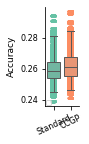

In [15]:
decoding_dir = resultdir + 'DecodingAnalyses/'
classifier = 'svm'
rule = 'Logic'
norm = ''
logic_dec = np.loadtxt(decoding_dir + 'Group' + rule + 'Decoding_' + classifier + norm + '.csv')
logic_ccgp = np.loadtxt(decoding_dir + 'Group' + rule + 'CCGP_' + classifier + norm +  '.csv')

# Plot bar plot and statistical testing
df_logic = {}
df_logic['Classifier'] = []
df_logic['Decoding'] = []
df_logic['Parcel'] = []
df_logic['Accuracy'] = []
for roi in range(nParcels): 
    for subj in range(len(subjNums)):
        df_logic['Classifier'].append(classifier)
        df_logic['Decoding'].append('Standard')
        df_logic['Parcel'].append(roi)
        df_logic['Accuracy'].append(logic_dec[roi])
        #
        df_logic['Classifier'].append(classifier)
        df_logic['Decoding'].append('CCGP')
        df_logic['Parcel'].append(roi)
        df_logic['Accuracy'].append(logic_ccgp[roi])
        
df_logic = pd.DataFrame(df_logic)

plt.figure(figsize=(1.3,2.1))
sns.stripplot(x="Decoding",y="Accuracy",data=df_logic,dodge=True,size=3,palette="Set2",zorder=0)
ax = sns.boxplot(x="Decoding",y="Accuracy",data=df_logic,sym='',whis=[2.5,97.5],palette="Set2",linewidth=1.0) #,order=hierarchy_ind,palette=networkpalette)
plt.xticks(rotation=25,fontsize=8)
# plt.xlabel('Network',fontsize=10);
plt.xlabel(None,fontsize=9)
plt.ylabel('Accuracy',fontsize=9);
plt.yticks(fontsize=8)
# plt.ylim([-0.55,1.2])
# plt.title('',fontsize=10)
# plt.title('Representational\nsegregation', fontsize=10);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[:2], labels[:2], loc=3, borderaxespad=0.2, prop={'size': 6})
plt.tight_layout()
sns.despine()

# Run statistical analyses
# t_dec, p_dec = stats.ttest_1samp(logic_dec,0.25,axis=1)
# q_dec = mc.fdrcorrection(p_dec)[1]
# t_ccgp, p_ccgp = stats.ttest_1samp(logic_ccgp,0.25,axis=1)
# q_ccgp = mc.fdrcorrection(p_ccgp)[1]

# Map to surface significant effects for decoding and ccgp
sig_effects = np.zeros((nParcels,2))
sig_effects[:,0] = logic_dec #np.multiply(np.mean(logic_dec,axis=1),q_dec<0.05)
sig_effects[:,1] = logic_ccgp #np.multiply(np.mean(logic_ccgp,axis=1),q_ccgp<0.05)

outfilename = decoding_dir + 'GroupSurface_' + rule + '_' + classifier + norm
mapBackToSurface(sig_effects,outfilename)

# Sensory rule decoding and CCGP

No handles with labels found to put in legend.


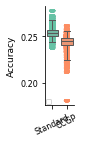

In [11]:
decoding_dir = resultdir + 'DecodingAnalyses/'
classifier = 'distance'
rule = 'Sensory'
norm = ''
sensory_dec = np.loadtxt(decoding_dir + 'Group' + rule + 'Decoding_' + classifier + norm + '.csv')
sensory_ccgp = np.loadtxt(decoding_dir + 'Group' + rule + 'CCGP_' + classifier + norm + '.csv')

# Plot bar plot and statistical testing
df_sensory = {}
df_sensory['Classifier'] = []
df_sensory['Decoding'] = []
df_sensory['Parcel'] = []
df_sensory['Accuracy'] = []
for roi in range(nParcels): 
    for subj in range(len(subjNums)):
        df_sensory['Classifier'].append(classifier)
        df_sensory['Decoding'].append('Standard')
        df_sensory['Parcel'].append(roi)
        df_sensory['Accuracy'].append(sensory_dec[roi])
        #
        df_sensory['Classifier'].append(classifier)
        df_sensory['Decoding'].append('CCGP')
        df_sensory['Parcel'].append(roi)
        df_sensory['Accuracy'].append(sensory_ccgp[roi])
        
df_sensory = pd.DataFrame(df_sensory)

plt.figure(figsize=(1.3,2.1))
sns.stripplot(x="Decoding",y="Accuracy",data=df_sensory,dodge=True,size=3,palette="Set2",zorder=0)
ax = sns.boxplot(x="Decoding",y="Accuracy",data=df_sensory,sym='',whis=[2.5,97.5],palette="Set2",linewidth=1.0) #,order=hierarchy_ind,palette=networkpalette)
plt.xticks(rotation=25,fontsize=8)
# plt.xlabel('Network',fontsize=10);
plt.xlabel(None,fontsize=9)
plt.ylabel('Accuracy',fontsize=9);
plt.yticks(fontsize=8)
# plt.ylim([-0.55,1.2])
# plt.title('',fontsize=10)
# plt.title('Representational\nsegregation', fontsize=10);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[:2], labels[:2], loc=3, borderaxespad=0.2, prop={'size': 6})
plt.tight_layout()
sns.despine()

# # Run statistical analyses
# t_dec, p_dec = stats.ttest_1samp(sensory_dec,0.25,axis=1)
# q_dec = mc.fdrcorrection(p_dec)[1]
# t_ccgp, p_ccgp = stats.ttest_1samp(sensory_ccgp,0.25,axis=1)
# q_ccgp = mc.fdrcorrection(p_ccgp)[1]

# Map to surface significant effects for decoding and ccgp
sig_effects = np.zeros((nParcels,2))
sig_effects[:,0] = sensory_dec #np.multiply(np.mean(sensory_dec,axis=1),q_dec<0.05)
sig_effects[:,1] = sensory_ccgp #np.multiply(np.mean(sensory_ccgp,axis=1),q_ccgp<0.05)

outfilename = decoding_dir + 'GroupSurface_' + rule + '_' + classifier + norm
mapBackToSurface(sig_effects,outfilename)

# GROUP Motor rule decoding and CCGP

No handles with labels found to put in legend.


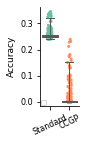

In [14]:
decoding_dir = resultdir + 'DecodingAnalyses/'
classifier = 'svm'
rule = 'Motor'
norm = ''
motor_dec = np.loadtxt(decoding_dir + 'Group' + rule + 'Decoding_' + classifier + norm + '.csv')
motor_ccgp = np.loadtxt(decoding_dir + 'Group' + rule + 'CCGP_' + classifier + norm + '.csv')

# Plot bar plot and statistical testing
df_motor = {}
df_motor['Classifier'] = []
df_motor['Decoding'] = []
df_motor['Parcel'] = []
df_motor['Accuracy'] = []
for roi in range(nParcels): 
    df_motor['Classifier'].append(classifier)
    df_motor['Decoding'].append('Standard')
    df_motor['Parcel'].append(roi)
    df_motor['Accuracy'].append(motor_dec[roi])
    #
    df_motor['Classifier'].append(classifier)
    df_motor['Decoding'].append('CCGP')
    df_motor['Parcel'].append(roi)
    df_motor['Accuracy'].append(motor_ccgp[roi])
        
df_motor = pd.DataFrame(df_motor)

plt.figure(figsize=(1.3,2.1))
sns.stripplot(x="Decoding",y="Accuracy",data=df_motor,dodge=True,size=3,palette="Set2",zorder=0)
ax = sns.boxplot(x="Decoding",y="Accuracy",data=df_motor,sym='',whis=[2.5,97.5],palette="Set2",linewidth=1.0) #,order=hierarchy_ind,palette=networkpalette)
plt.xticks(rotation=25,fontsize=8)
# plt.xlabel('Network',fontsize=10);
plt.xlabel(None,fontsize=9)
plt.ylabel('Accuracy',fontsize=9);
plt.yticks(fontsize=8)
# plt.ylim([-0.55,1.2])
# plt.title('',fontsize=10)
# plt.title('Representational\nsegregation', fontsize=10);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[:2], labels[:2], loc=3, borderaxespad=0.2, prop={'size': 6})
plt.tight_layout()
sns.despine()

# Run statistical analyses
# t_dec, p_dec = stats.ttest_1samp(motor_dec,0.25,axis=1)
# q_dec = mc.fdrcorrection(p_dec)[1]
# t_ccgp, p_ccgp = stats.ttest_1samp(motor_ccgp,0.25,axis=1)
# q_ccgp = mc.fdrcorrection(p_ccgp)[1]

# Map to surface significant effects for decoding and ccgp
sig_effects = np.zeros((nParcels,2))
sig_effects[:,0] = motor_dec #np.multiply(np.mean(motor_dec,axis=1),q_dec<.05)
sig_effects[:,1] = motor_ccgp #np.multiply(np.mean(motor_ccgp,axis=1),q_ccgp<.05)

outfilename = decoding_dir + 'GroupSurface_' + rule + '_' + classifier + norm
mapBackToSurface(sig_effects,outfilename)